In [1]:
import numpy as np
import h5py
import time
import json
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
import torch.nn.functional as F

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
x_train_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_train_x.h5"
y_train_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_train_y.h5"

x_valid_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_valid_x.h5"
y_valid_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_valid_y.h5"

x_test_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_test_x.h5"
y_test_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_test_y.h5"

In [3]:
class PCamDataset(Dataset):
    def __init__(self, x_path, y_path, transform):
        self.transform = transform

        with h5py.File(x_path, "r") as file_x, h5py.File(y_path, "r") as file_y:
            self.images = file_x["x"][:]
            self.labels = file_y["y"][:]

        self.length = len(self.images)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]

        img = self.transform(img)
        label = torch.tensor(label, dtype=torch.float32).squeeze()

        return img, label

In [4]:
def compute_metrics(labels, preds, probs):
    labels = np.array(labels)
    preds = np.array(preds)
    probs = np.array(probs)

    accuracy = 100 * accuracy_score(labels, preds)

    if np.sum(preds) == 0:
        precision = 0.0
        recall = 0.0
        f1 = 0.0
    else:
        precision = precision_score(labels, preds, average="binary")
        recall = recall_score(labels, preds, average="binary")
        f1 = f1_score(labels, preds, average="binary")

    if np.sum(labels) == 0 or np.sum(preds) == 0:
        roc_auc = 0.0
        pr_auc = 0.0
    else:
        roc_auc = roc_auc_score(labels, probs)
        pr_auc = average_precision_score(labels, probs)

    return {
        "accuracies": accuracy,
        "precisions": precision,
        "recalls": recall,
        "f1s": f1,
        "rocs": roc_auc,
        "prs": pr_auc,
    }


def round_metrics(metrics, decimals=4):
    def round_value(value):
        if isinstance(value, float):
            return round(value, decimals)
        elif isinstance(value, list):
            return [round_value(v) for v in value]
        elif isinstance(value, tuple):
            return tuple(round_value(v) for v in value)
        elif isinstance(value, dict):
            return {k: round_value(v) for k, v in value.items()}
        return value

    return {key: round_value(values) for key, values in metrics.items()}

In [5]:
def plot_metrics(epochs_range, train_vals, val_vals, ylabel, title):
    plt.plot(epochs_range, train_vals, label="Train")
    plt.plot(epochs_range, val_vals, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()

In [6]:
def test_model(model, test_loader):
    running_test_loss = 0.0
    test_preds, test_labels, test_probs = [], [], []

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()

            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.detach().cpu().numpy())

    running_test_loss /= len(test_loader)
    test_metrics = compute_metrics(test_labels, test_preds, test_probs)

    print(
        f"Test Loss: {running_test_loss:.4f}, "
        f"Acc: {test_metrics['accuracies']:.4f}%, "
        f"F1: {test_metrics['f1s']:.4f}\n"
    )

    return test_metrics

In [7]:
def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
):
    metrics = {
        "losses": ([], []),
        "accuracies": ([], []),
        "precisions": ([], []),
        "recalls": ([], []),
        "f1s": ([], []),
        "rocs": ([], []),
        "prs": ([], []),
    }

    test_metrics = {}
    best_test_accuracy = 0.0

    total_train_time, total_val_time = 0, 0

    for epoch in range(1, epochs + 1):
        model.train()
        start_time = time.time()
        running_train_loss = 0.0
        train_preds, train_labels, train_probs = [], [], []

        for images, labels in tqdm(
            train_loader, desc=f"Epoch {epoch}/{epochs} - Training", leave=False
        ):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()

            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.detach().cpu().numpy())

        total_train_time += time.time() - start_time
        train_metrics = compute_metrics(train_labels, train_preds, train_probs)

        if scheduler is not None:
            scheduler.step()

        model.eval()
        with torch.no_grad():
            start_time = time.time()
            running_val_loss = 0.0
            val_preds, val_labels, val_probs = [], [], []

            for images, labels in tqdm(
                val_loader, desc=f"Epoch {epoch}/{epochs} - Validation", leave=False
            ):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze(dim=1)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).long()

                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.detach().cpu().numpy())

            total_val_time += time.time() - start_time
            val_metrics = compute_metrics(val_labels, val_preds, val_probs)

        running_train_loss /= len(train_loader)
        running_val_loss /= len(val_loader)

        metrics["losses"][0].append(running_train_loss)
        metrics["losses"][1].append(running_val_loss)

        for key in metrics.keys():
            if key != "losses":
                metrics[key][0].append(train_metrics[key])
                metrics[key][1].append(val_metrics[key])

        print(
            f"Epoch [{epoch}/{epochs}]:\n"
            f"Train Loss: {metrics['losses'][0][-1]:.4f}, "
            f"Acc: {metrics['accuracies'][0][-1]:.4f}%, "
            f"F1: {metrics['f1s'][0][-1]:.4f}\n"
            f"Val Loss: {metrics['losses'][1][-1]:.4f}, "
            f"Acc: {metrics['accuracies'][1][-1]:.4f}%, "
            f"F1: {metrics['f1s'][1][-1]:.4f}\n"
        )

        if epoch == 10 or epoch == 15 or epoch == 25:
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": (
                    scheduler.state_dict() if scheduler is not None else None
                ),
            }
            torch.save(checkpoint, f"model_{epoch}.pth")

        test_met = test_model(model, test_loader)
        test_metrics[f"Testing_{epoch}"] = test_met

        test_accuracy = test_met["accuracies"]

        if epoch == 10 or epoch == 15 or epoch == 25:
            print(f"Test Accuracy at epoch: {epoch} is {test_accuracy} %\n")
            
        if test_accuracy >= best_test_accuracy:
            best_test_accuracy = test_accuracy
            print(f"Best Model saving at epoch: {epoch} with accuracy: {test_accuracy} %\n")
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": (
                    scheduler.state_dict() if scheduler is not None else None
                ),
            }
            torch.save(checkpoint, f"model_best.pth")

    total_train_time /= 60
    total_val_time /= 60

    print(f"Best test accuracy: {best_test_accuracy} %\n")
    print(
        f"Total Training Time: {(total_train_time):.2f} min, Validation Time: {(total_val_time):.2f} min"
    )

    metrics["total_times"] = {
        "training_time (mins)": total_train_time,
        "validation_time (mins)": total_val_time,
    }
    metrics["Testing"] = test_metrics

    return metrics

In [8]:
train_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=(96, 96), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.Resize((96, 96)),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


train_dataset = PCamDataset(x_train_path, y_train_path, transform=train_transform)
val_dataset = PCamDataset(x_valid_path, y_valid_path, transform=test_transform)
test_dataset = PCamDataset(x_test_path, y_test_path, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

In [9]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1
        self.conv = DepthwiseSeparableConv(in_channels, out_channels, kernel_size=3, stride=stride)
        self.shortcut = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False) 
            if in_channels != out_channels or downsample else nn.Identity()
        )
        self.dropout = nn.Dropout2d(0.2)
    
    def forward(self, x):
        out = self.conv(x) + self.shortcut(x)
        return self.dropout(out)

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=False)
        self.conv3x3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.conv5x5 = nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels * 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(0.2)
    
    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3(x)
        x3 = self.conv5x5(x)
        x = torch.cat([x1, x2, x3], dim=1)  
        x = self.bn(x)
        x = self.relu(x)
        return self.dropout(x)

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.init_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.res_block1 = ResidualBlock(64, 64)
        self.res_block2 = ResidualBlock(64, 128, downsample=True) 
        self.res_block3 = ResidualBlock(128, 256, downsample=True) 
        self.inception = InceptionModule(256, 256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((6,6))
        self.fc = nn.Sequential(
            nn.Linear(256 * 3 * 6 * 6, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )
    
    def forward(self, x):
        x = self.init_conv(x)        
        x = self.res_block1(x)        
        x = self.res_block2(x)        
        x = self.res_block3(x)        
        x = self.inception(x)        
        x = self.global_avg_pool(x)        
        x = torch.flatten(x, 1)        
        x = self.fc(x)
        
        return x

In [10]:
model = CustomCNN()
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = None

epochs = 70

print(model)

CustomCNN(
  (init_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (res_block1): ResidualBlock(
    (conv): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (shortcut): Identity()
    (dropout): Dropout2d(p=0.2, inplace=False)
  )
  (res_block2): ResidualBlock(
    (conv): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, aff

Epoch [1/70]:
Train Loss: 0.5237, Acc: 74.6895%, F1: 0.7488
Val Loss: 0.4727, Acc: 77.1240%, F1: 0.7645



Test Loss: 0.4993, Acc: 76.2909%, F1: 0.7567

Best Model saving at epoch: 1 with accuracy: 76.2908935546875 %



Epoch [2/70]:
Train Loss: 0.4905, Acc: 77.0752%, F1: 0.7752
Val Loss: 0.4567, Acc: 78.5004%, F1: 0.7968



Test Loss: 0.4741, Acc: 78.7384%, F1: 0.8009

Best Model saving at epoch: 2 with accuracy: 78.7384033203125 %



Epoch [3/70]:
Train Loss: 0.4757, Acc: 77.8885%, F1: 0.7836
Val Loss: 0.4478, Acc: 79.7699%, F1: 0.8099



Test Loss: 0.4755, Acc: 78.3264%, F1: 0.7949



Epoch [4/70]:
Train Loss: 0.4656, Acc: 78.4569%, F1: 0.7888
Val Loss: 0.4331, Acc: 78.8483%, F1: 0.7942



Test Loss: 0.4570, Acc: 79.0771%, F1: 0.7979

Best Model saving at epoch: 4 with accuracy: 79.0771484375 %



Epoch [5/70]:
Train Loss: 0.4563, Acc: 79.0688%, F1: 0.7947
Val Loss: 0.4318, Acc: 80.1422%, F1: 0.8134



Test Loss: 0.4405, Acc: 80.4810%, F1: 0.8186

Best Model saving at epoch: 5 with accuracy: 80.48095703125 %



Epoch [6/70]:
Train Loss: 0.4473, Acc: 79.6143%, F1: 0.7997
Val Loss: 0.4179, Acc: 79.5837%, F1: 0.7949



Test Loss: 0.4311, Acc: 79.7241%, F1: 0.7971



Epoch [7/70]:
Train Loss: 0.4389, Acc: 80.0629%, F1: 0.8036
Val Loss: 0.4163, Acc: 79.4891%, F1: 0.7981



Test Loss: 0.4419, Acc: 79.2694%, F1: 0.7948



Epoch [8/70]:
Train Loss: 0.4318, Acc: 80.4497%, F1: 0.8074
Val Loss: 0.4060, Acc: 81.0669%, F1: 0.8149



Test Loss: 0.4236, Acc: 80.3558%, F1: 0.8057



Epoch [9/70]:
Train Loss: 0.4255, Acc: 80.7621%, F1: 0.8096
Val Loss: 0.3966, Acc: 81.0760%, F1: 0.8181



Test Loss: 0.4308, Acc: 79.8492%, F1: 0.8018



Epoch [10/70]:
Train Loss: 0.4204, Acc: 81.0337%, F1: 0.8124
Val Loss: 0.4028, Acc: 81.0516%, F1: 0.8147



Test Loss: 0.4305, Acc: 79.6234%, F1: 0.7945

Test Accuracy at epoch: 10 is 79.6234130859375 %



Epoch [11/70]:
Train Loss: 0.4152, Acc: 81.3286%, F1: 0.8155
Val Loss: 0.4019, Acc: 81.1859%, F1: 0.8178



Test Loss: 0.4329, Acc: 79.5288%, F1: 0.7963



Epoch [12/70]:
Train Loss: 0.4092, Acc: 81.6769%, F1: 0.8184
Val Loss: 0.3947, Acc: 81.6498%, F1: 0.8116



Test Loss: 0.4499, Acc: 78.1342%, F1: 0.7623



Epoch [13/70]:
Train Loss: 0.4043, Acc: 81.9290%, F1: 0.8209
Val Loss: 0.3932, Acc: 82.3090%, F1: 0.8244



Test Loss: 0.4208, Acc: 79.7638%, F1: 0.7896



Epoch [14/70]:
Train Loss: 0.3983, Acc: 82.2453%, F1: 0.8237
Val Loss: 0.3818, Acc: 82.3517%, F1: 0.8264



Test Loss: 0.4246, Acc: 79.6570%, F1: 0.7907



Epoch [15/70]:
Train Loss: 0.3923, Acc: 82.5592%, F1: 0.8265
Val Loss: 0.3726, Acc: 83.0353%, F1: 0.8385



Test Loss: 0.4180, Acc: 80.5878%, F1: 0.8058

Test Accuracy at epoch: 15 is 80.5877685546875 %

Best Model saving at epoch: 15 with accuracy: 80.5877685546875 %



Epoch [16/70]:
Train Loss: 0.3878, Acc: 82.9216%, F1: 0.8299
Val Loss: 0.3914, Acc: 82.1320%, F1: 0.8246



Test Loss: 0.4274, Acc: 79.9713%, F1: 0.7974



Epoch [17/70]:
Train Loss: 0.3815, Acc: 83.1841%, F1: 0.8327
Val Loss: 0.3654, Acc: 83.3374%, F1: 0.8359



Test Loss: 0.4089, Acc: 81.3019%, F1: 0.8093

Best Model saving at epoch: 17 with accuracy: 81.3018798828125 %



Epoch [18/70]:
Train Loss: 0.3765, Acc: 83.4049%, F1: 0.8346
Val Loss: 0.3612, Acc: 83.9325%, F1: 0.8431



Test Loss: 0.4006, Acc: 81.3171%, F1: 0.8093

Best Model saving at epoch: 18 with accuracy: 81.317138671875 %



Epoch [19/70]:
Train Loss: 0.3710, Acc: 83.7406%, F1: 0.8379
Val Loss: 0.3786, Acc: 83.1543%, F1: 0.8187



Test Loss: 0.4667, Acc: 78.5553%, F1: 0.7524



Epoch [20/70]:
Train Loss: 0.3666, Acc: 84.0149%, F1: 0.8406
Val Loss: 0.3638, Acc: 83.7982%, F1: 0.8341



Test Loss: 0.4430, Acc: 79.1931%, F1: 0.7728



Epoch [21/70]:
Train Loss: 0.3631, Acc: 84.1812%, F1: 0.8421
Val Loss: 0.3542, Acc: 84.3170%, F1: 0.8450



Test Loss: 0.4143, Acc: 81.1096%, F1: 0.8030



Epoch [22/70]:
Train Loss: 0.3578, Acc: 84.4273%, F1: 0.8443
Val Loss: 0.3529, Acc: 84.0729%, F1: 0.8413



Test Loss: 0.4334, Acc: 79.6265%, F1: 0.7841



Epoch [23/70]:
Train Loss: 0.3547, Acc: 84.6466%, F1: 0.8464
Val Loss: 0.3387, Acc: 85.0098%, F1: 0.8456



Test Loss: 0.4018, Acc: 81.0181%, F1: 0.7925



Epoch [24/70]:
Train Loss: 0.3502, Acc: 84.9815%, F1: 0.8497
Val Loss: 0.3383, Acc: 85.1685%, F1: 0.8533



Test Loss: 0.4059, Acc: 81.1951%, F1: 0.8025



Epoch [25/70]:
Train Loss: 0.3472, Acc: 85.0018%, F1: 0.8499
Val Loss: 0.3396, Acc: 85.0189%, F1: 0.8478



Test Loss: 0.4102, Acc: 80.5054%, F1: 0.7869

Test Accuracy at epoch: 25 is 80.50537109375 %



Epoch [26/70]:
Train Loss: 0.3423, Acc: 85.3088%, F1: 0.8529
Val Loss: 0.3283, Acc: 85.6659%, F1: 0.8529



Test Loss: 0.4227, Acc: 80.3253%, F1: 0.7816



Epoch [27/70]:
Train Loss: 0.3388, Acc: 85.4473%, F1: 0.8542
Val Loss: 0.3236, Acc: 85.6140%, F1: 0.8574



Test Loss: 0.4311, Acc: 80.6335%, F1: 0.7937



Epoch [28/70]:
Train Loss: 0.3361, Acc: 85.6628%, F1: 0.8563
Val Loss: 0.3315, Acc: 85.3577%, F1: 0.8491



Test Loss: 0.4004, Acc: 81.1859%, F1: 0.7926



Epoch [29/70]:
Train Loss: 0.3329, Acc: 85.8112%, F1: 0.8577
Val Loss: 0.3247, Acc: 85.8551%, F1: 0.8570



Test Loss: 0.3930, Acc: 82.0465%, F1: 0.8070

Best Model saving at epoch: 29 with accuracy: 82.0465087890625 %



Epoch [30/70]:
Train Loss: 0.3286, Acc: 85.9425%, F1: 0.8590
Val Loss: 0.3208, Acc: 86.0870%, F1: 0.8599



Test Loss: 0.3790, Acc: 82.4158%, F1: 0.8129

Best Model saving at epoch: 30 with accuracy: 82.415771484375 %



Epoch [31/70]:
Train Loss: 0.3254, Acc: 86.2080%, F1: 0.8616
Val Loss: 0.3291, Acc: 86.0291%, F1: 0.8563



Test Loss: 0.3978, Acc: 81.8054%, F1: 0.8008



Epoch [32/70]:
Train Loss: 0.3222, Acc: 86.3422%, F1: 0.8629
Val Loss: 0.3249, Acc: 85.8948%, F1: 0.8541



Test Loss: 0.4199, Acc: 81.0455%, F1: 0.7891



Epoch [33/70]:
Train Loss: 0.3183, Acc: 86.5135%, F1: 0.8646
Val Loss: 0.3412, Acc: 85.6262%, F1: 0.8503



Test Loss: 0.4171, Acc: 81.1584%, F1: 0.7894



Epoch [34/70]:
Train Loss: 0.3159, Acc: 86.6333%, F1: 0.8657
Val Loss: 0.3056, Acc: 87.1002%, F1: 0.8673



Test Loss: 0.3642, Acc: 83.2336%, F1: 0.8175

Best Model saving at epoch: 34 with accuracy: 83.233642578125 %



Epoch [35/70]:
Train Loss: 0.3131, Acc: 86.8027%, F1: 0.8672
Val Loss: 0.3447, Acc: 85.5988%, F1: 0.8455



Test Loss: 0.4335, Acc: 81.1371%, F1: 0.7832



Epoch [36/70]:
Train Loss: 0.3090, Acc: 86.9972%, F1: 0.8693
Val Loss: 0.3049, Acc: 87.2040%, F1: 0.8687



Test Loss: 0.3523, Acc: 84.1278%, F1: 0.8289

Best Model saving at epoch: 36 with accuracy: 84.1278076171875 %



Epoch [37/70]:
Train Loss: 0.3061, Acc: 87.1727%, F1: 0.8710
Val Loss: 0.3129, Acc: 86.5417%, F1: 0.8620



Test Loss: 0.3977, Acc: 82.3547%, F1: 0.8066



Epoch [38/70]:
Train Loss: 0.3050, Acc: 87.2650%, F1: 0.8719
Val Loss: 0.3002, Acc: 87.4634%, F1: 0.8723



Test Loss: 0.3738, Acc: 83.3069%, F1: 0.8189



Epoch [39/70]:
Train Loss: 0.3017, Acc: 87.3878%, F1: 0.8731
Val Loss: 0.3098, Acc: 86.8835%, F1: 0.8651



Test Loss: 0.3563, Acc: 83.7891%, F1: 0.8250



Epoch [40/70]:
Train Loss: 0.3007, Acc: 87.4458%, F1: 0.8737
Val Loss: 0.3157, Acc: 87.1429%, F1: 0.8642



Test Loss: 0.3688, Acc: 83.3435%, F1: 0.8142



Epoch [41/70]:
Train Loss: 0.2964, Acc: 87.6774%, F1: 0.8760
Val Loss: 0.3041, Acc: 87.3352%, F1: 0.8690



Test Loss: 0.3516, Acc: 84.4940%, F1: 0.8315

Best Model saving at epoch: 41 with accuracy: 84.4940185546875 %



Epoch [42/70]:
Train Loss: 0.2950, Acc: 87.7975%, F1: 0.8773
Val Loss: 0.2891, Acc: 87.6862%, F1: 0.8772



Test Loss: 0.3294, Acc: 85.2722%, F1: 0.8460

Best Model saving at epoch: 42 with accuracy: 85.272216796875 %



Epoch [43/70]:
Train Loss: 0.2933, Acc: 87.8166%, F1: 0.8772
Val Loss: 0.3098, Acc: 87.2986%, F1: 0.8653



Test Loss: 0.4000, Acc: 82.5195%, F1: 0.8018



Epoch [44/70]:
Train Loss: 0.2908, Acc: 87.9593%, F1: 0.8786
Val Loss: 0.3003, Acc: 87.5122%, F1: 0.8745



Test Loss: 0.3635, Acc: 83.9813%, F1: 0.8294



Epoch [45/70]:
Train Loss: 0.2884, Acc: 88.1500%, F1: 0.8806
Val Loss: 0.3408, Acc: 85.7849%, F1: 0.8480



Test Loss: 0.4172, Acc: 82.0007%, F1: 0.7969



Epoch [46/70]:
Train Loss: 0.2868, Acc: 88.1760%, F1: 0.8808
Val Loss: 0.3076, Acc: 87.1552%, F1: 0.8658



Test Loss: 0.3673, Acc: 83.7372%, F1: 0.8215



Epoch [47/70]:
Train Loss: 0.2841, Acc: 88.2755%, F1: 0.8818
Val Loss: 0.3100, Acc: 87.1765%, F1: 0.8660



Test Loss: 0.3667, Acc: 83.3679%, F1: 0.8156



Epoch [48/70]:
Train Loss: 0.2832, Acc: 88.3080%, F1: 0.8821
Val Loss: 0.3101, Acc: 87.2375%, F1: 0.8657



Test Loss: 0.3631, Acc: 83.8287%, F1: 0.8211



Epoch [49/70]:
Train Loss: 0.2822, Acc: 88.3831%, F1: 0.8829
Val Loss: 0.3010, Acc: 87.5885%, F1: 0.8708



Test Loss: 0.3556, Acc: 84.0118%, F1: 0.8250



Epoch [50/70]:
Train Loss: 0.2795, Acc: 88.4766%, F1: 0.8839
Val Loss: 0.3020, Acc: 87.5214%, F1: 0.8718



Test Loss: 0.3497, Acc: 84.8511%, F1: 0.8372



Epoch [51/70]:
Train Loss: 0.2769, Acc: 88.6189%, F1: 0.8853
Val Loss: 0.3186, Acc: 87.0667%, F1: 0.8670



Test Loss: 0.3618, Acc: 84.2621%, F1: 0.8303



Epoch [52/70]:
Train Loss: 0.2751, Acc: 88.7440%, F1: 0.8865
Val Loss: 0.2953, Acc: 87.9974%, F1: 0.8779



Test Loss: 0.3172, Acc: 86.3647%, F1: 0.8568

Best Model saving at epoch: 52 with accuracy: 86.36474609375 %



Epoch [53/70]:
Train Loss: 0.2738, Acc: 88.7856%, F1: 0.8868
Val Loss: 0.3023, Acc: 87.7228%, F1: 0.8746



Test Loss: 0.3282, Acc: 85.5530%, F1: 0.8467



Epoch [54/70]:
Train Loss: 0.2721, Acc: 88.9015%, F1: 0.8880
Val Loss: 0.3004, Acc: 87.9364%, F1: 0.8736



Test Loss: 0.3528, Acc: 84.2682%, F1: 0.8263



Epoch [55/70]:
Train Loss: 0.2716, Acc: 88.9057%, F1: 0.8881
Val Loss: 0.2954, Acc: 87.7930%, F1: 0.8742



Test Loss: 0.3386, Acc: 85.1166%, F1: 0.8395



Epoch [56/70]:
Train Loss: 0.2699, Acc: 89.0377%, F1: 0.8894
Val Loss: 0.3163, Acc: 87.4329%, F1: 0.8697



Test Loss: 0.3689, Acc: 83.9386%, F1: 0.8244



Epoch [57/70]:
Train Loss: 0.2677, Acc: 89.0610%, F1: 0.8896
Val Loss: 0.2994, Acc: 87.7502%, F1: 0.8737



Test Loss: 0.3300, Acc: 85.7544%, F1: 0.8477



Epoch [58/70]:
Train Loss: 0.2667, Acc: 89.1483%, F1: 0.8905
Val Loss: 0.2990, Acc: 87.6190%, F1: 0.8757



Test Loss: 0.3240, Acc: 85.9558%, F1: 0.8541



Epoch [59/70]:
Train Loss: 0.2657, Acc: 89.1293%, F1: 0.8902
Val Loss: 0.2973, Acc: 87.4725%, F1: 0.8691



Test Loss: 0.3686, Acc: 84.2773%, F1: 0.8278



Epoch [60/70]:
Train Loss: 0.2631, Acc: 89.2815%, F1: 0.8919
Val Loss: 0.3063, Acc: 87.4908%, F1: 0.8708



Test Loss: 0.3676, Acc: 84.3018%, F1: 0.8292



Epoch [61/70]:
Train Loss: 0.2632, Acc: 89.2807%, F1: 0.8918
Val Loss: 0.3178, Acc: 87.4786%, F1: 0.8674



Test Loss: 0.3883, Acc: 83.6761%, F1: 0.8178



Epoch [62/70]:
Train Loss: 0.2622, Acc: 89.3929%, F1: 0.8929
Val Loss: 0.2994, Acc: 87.5031%, F1: 0.8685



Test Loss: 0.3578, Acc: 84.2834%, F1: 0.8265



Epoch [63/70]:
Train Loss: 0.2613, Acc: 89.3772%, F1: 0.8927
Val Loss: 0.2819, Acc: 88.4460%, F1: 0.8822



Test Loss: 0.3413, Acc: 85.3638%, F1: 0.8436



Epoch [64/70]:
Train Loss: 0.2587, Acc: 89.5309%, F1: 0.8943
Val Loss: 0.2783, Acc: 88.6993%, F1: 0.8818



Test Loss: 0.3511, Acc: 84.8969%, F1: 0.8341



Epoch [65/70]:
Train Loss: 0.2583, Acc: 89.5622%, F1: 0.8946
Val Loss: 0.2745, Acc: 88.6658%, F1: 0.8854



Test Loss: 0.3233, Acc: 86.1511%, F1: 0.8544



Epoch [66/70]:
Train Loss: 0.2572, Acc: 89.6183%, F1: 0.8952
Val Loss: 0.2994, Acc: 87.6556%, F1: 0.8720



Test Loss: 0.3186, Acc: 85.6537%, F1: 0.8459



Epoch [67/70]:
Train Loss: 0.2563, Acc: 89.6461%, F1: 0.8954
Val Loss: 0.3080, Acc: 87.6648%, F1: 0.8681



Test Loss: 0.3703, Acc: 84.2377%, F1: 0.8232



Epoch [68/70]:
Train Loss: 0.2554, Acc: 89.6858%, F1: 0.8959
Val Loss: 0.3101, Acc: 87.6587%, F1: 0.8703



Test Loss: 0.3453, Acc: 85.1501%, F1: 0.8374



Epoch [69/70]:
Train Loss: 0.2543, Acc: 89.8022%, F1: 0.8970
Val Loss: 0.2877, Acc: 88.6475%, F1: 0.8828



Test Loss: 0.3085, Acc: 86.3556%, F1: 0.8539



Epoch [70/70]:
Train Loss: 0.2527, Acc: 89.8258%, F1: 0.8972
Val Loss: 0.2914, Acc: 88.1989%, F1: 0.8761



Test Loss: 0.3215, Acc: 85.8093%, F1: 0.8451

Best test accuracy: 86.36474609375 %

Total Training Time: 500.89 min, Validation Time: 13.93 min


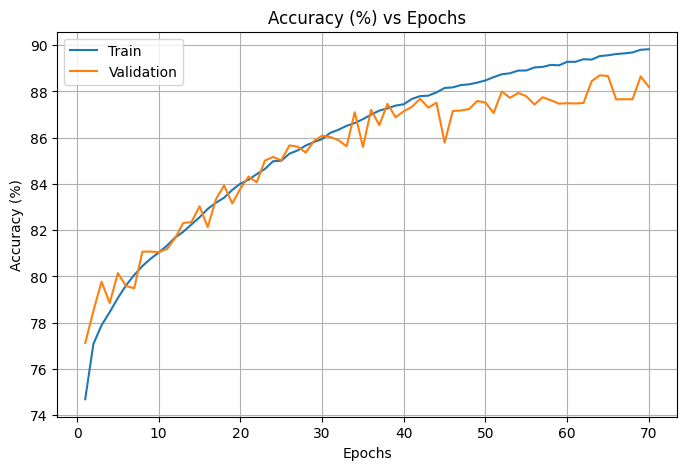

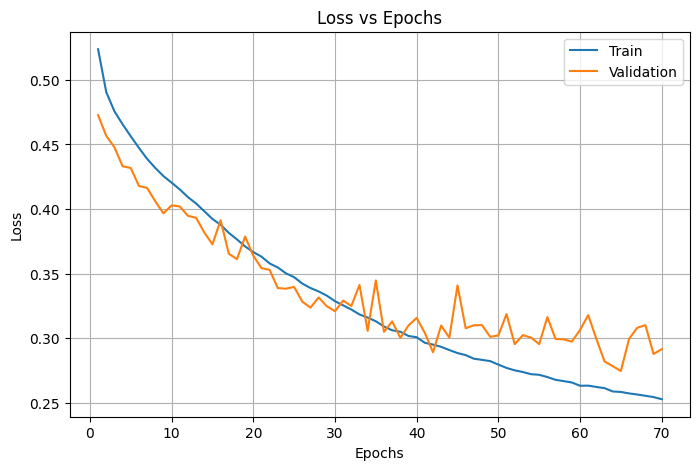

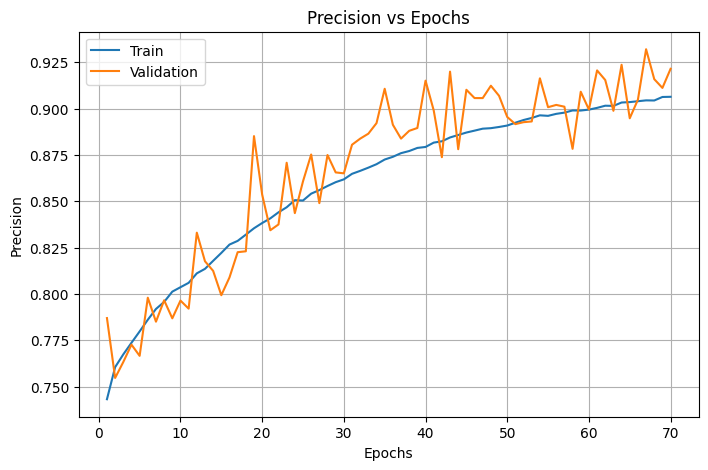

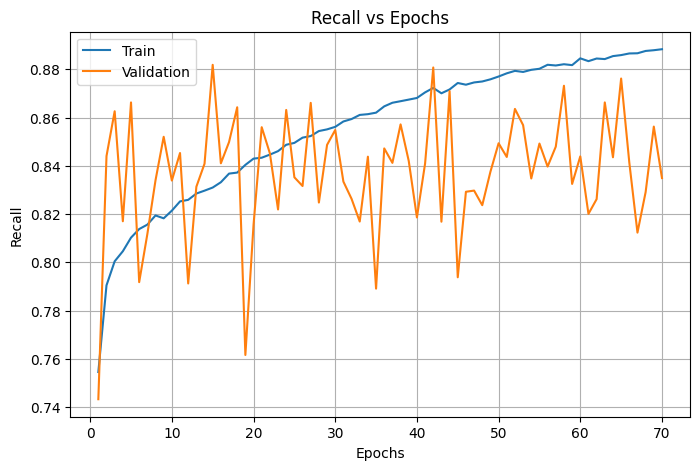

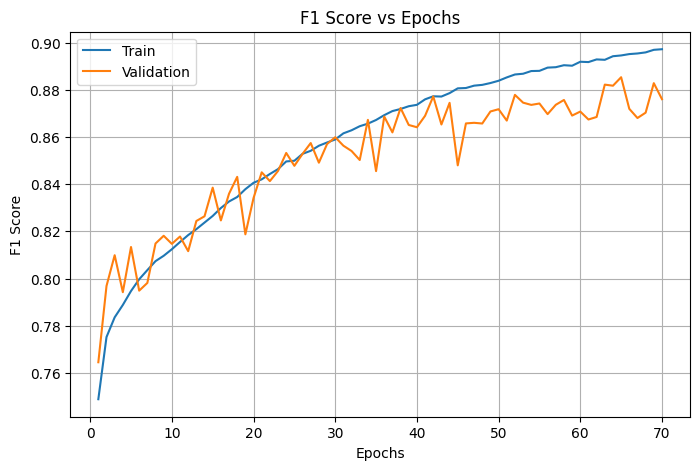

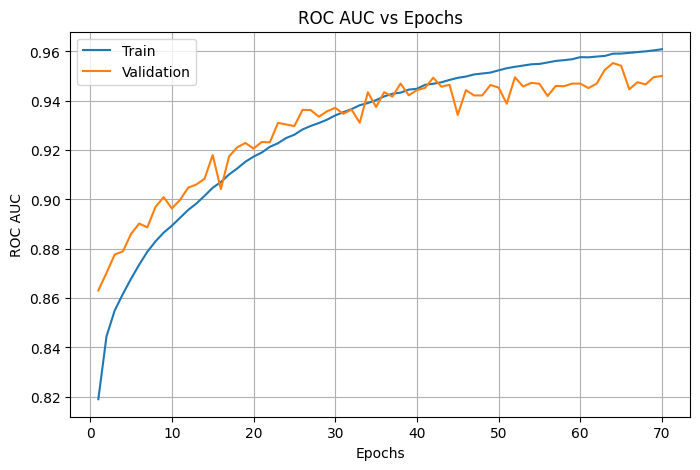

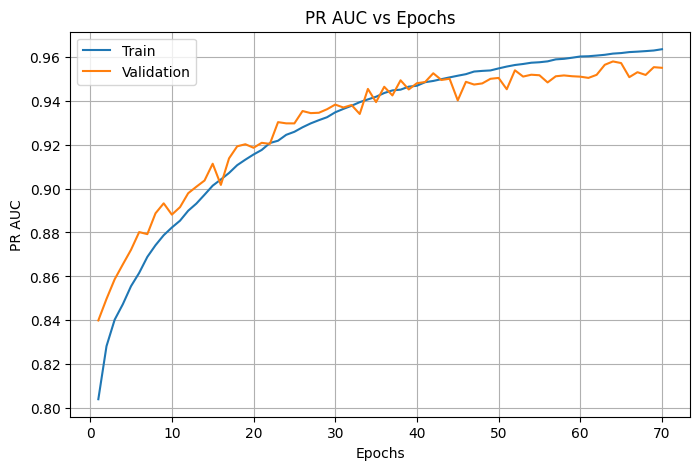

In [11]:
train_metrics = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
)

with open("metrics.json", "w") as f:
    json.dump(round_metrics(train_metrics), f, indent=4)

epochs_range = range(1, epochs + 1)

metric_names = [
    "accuracies",
    "losses",
    "precisions",
    "recalls",
    "f1s",
    "rocs",
    "prs",
]
metric_labels = [
    "Accuracy (%)",
    "Loss",
    "Precision",
    "Recall",
    "F1 Score",
    "ROC AUC",
    "PR AUC",
]

for metric, label in zip(metric_names, metric_labels):
    plt.figure(figsize=(8, 5))
    plot_metrics(epochs_range, *train_metrics[metric], label, f"{label} vs Epochs")
    plt.savefig(f"{metric}.png", bbox_inches="tight")
    plt.show()
    plt.close()